<a href="https://colab.research.google.com/github/paularedondosastre/APRENDIZAJE_AUTOMATICO_23_24/blob/main/Copia_con_vectores_9MB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opendatasets

In [ ]:
pip install pandas

In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/arjunbasandrai/25-indian-bird-species-with-226k-images/code")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: luciacasas
Your Kaggle Key: ··········


100%|██████████| 9.33G/9.33G [02:25<00:00, 68.9MB/s]


In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import Counter

import glob
import cv2

from pathlib import Path
from PIL import Image

from sklearn import preprocessing

import keras
from keras.callbacks import Callback

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, PReLU
from tensorflow.keras import regularizers

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [ ]:
data_dir = './25-indian-bird-species-with-226k-images/training_set/training_set'

def load_train():

    train_data = []
    train_labels = []
    val_data = []
    val_labels = []
    test_data = []
    test_labels = []

    for clase in os.listdir(data_dir):
        clase_dir = os.path.join(data_dir, clase)

        # Use glob.glob to find JPG files in the directory
        train_clase = glob.glob(os.path.join(clase_dir, '*.jpg'))
        num = len(train_clase)
        i = 0

        for img in train_clase:
            if i < 0.7*num:
              train_data.append(img)
              train_labels.append(clase)
            elif i < 0.85*num:
              val_data.append(img)
              val_labels.append(clase)
            else:
              test_data.append(img)
              test_labels.append(clase)
            i += 1

    dftrain = pd.DataFrame()
    dftrain['images'] = train_data
    dftrain['labels'] = train_labels
    dftrain = dftrain.sample(frac=1).reset_index(drop=True)

    dfval = pd.DataFrame()
    dfval['images'] = val_data
    dfval['labels'] = val_labels
    dfval = dfval.sample(frac=1).reset_index(drop=True)

    dftest = pd.DataFrame()
    dftest['images'] = test_data
    dftest['labels'] = test_labels
    dftest = dftest.sample(frac=1).reset_index(drop=True)

    return dftrain, dfval, dftest


In [ ]:
dftrain, dfval, dftest = load_train()
dftrain.shape

(15842, 2)

Pasar etiqueta de texto a número enteros

In [ ]:
# ESTO FALLA

from sklearn import preprocessing
pre = preprocessing.LabelEncoder()

dftrain['labels']= pre.fit_transform(dftrain['labels'])
dfval['labels']= pre.fit_transform(dfval['labels'])
dftest['labels']= pre.fit_transform(dftest['labels'])

Comprobamos si todas las clases tienen la misma representatividad en cada una de las particiones de datos generadas.

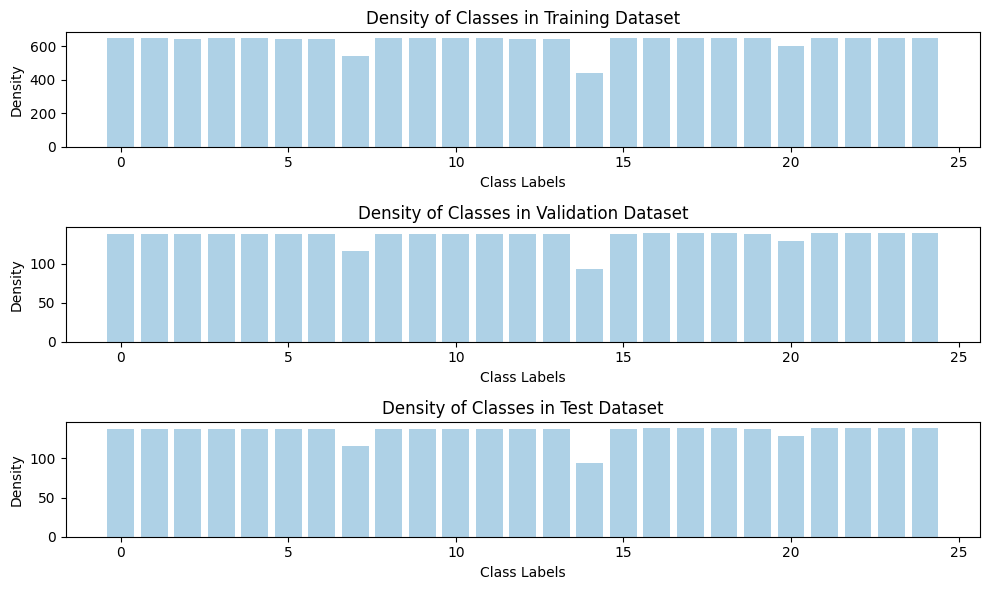

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.bar(dftrain['labels'].value_counts().index, dftrain['labels'].value_counts().values, color='#AED1E6')
plt.xlabel('Class Labels')
plt.ylabel('Density')
plt.title(f'Density of Classes in Training Dataset')

plt.subplot(3, 1, 2)
plt.bar(dfval['labels'].value_counts().index, dfval['labels'].value_counts().values, color='#AED1E6')
plt.xlabel('Class Labels')
plt.ylabel('Density')
plt.title(f'Density of Classes in Validation Dataset')

plt.subplot(3, 1, 3)
plt.bar(dftest['labels'].value_counts().index, dftest['labels'].value_counts().values, color='#AED1E6')
plt.xlabel('Class Labels')
plt.ylabel('Density')
plt.title(f'Density of Classes in Test Dataset')

plt.tight_layout()
plt.show()

A partir de las tablas de datos que se han cargado, guardamos la información en arrays.

In [ ]:
def prepare_load(train_clase, image_size):

    data = []
    labels = []

    for i in range(len(train_clase.iloc[:, 0])):
      img = cv2.imread(str(train_clase.iloc[i, 0]))
      if img is None:
            print(f"Could not read image: {i} {img}")
            continue
      img = cv2.resize(img, (image_size, image_size))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img.astype(np.float32)/255.

      data.append(img)
      labels.append(train_clase.iloc[i, 1])

    return np.array(data), np.array(labels)


In [ ]:
train_images, train_labels = prepare_load(dftrain, 128)
val_images, val_labels = prepare_load(dfval, 128)
test_images, test_labels = prepare_load(dftest, 128)

Could not read image: 2829 None
Could not read image: 12802 None
Could not read image: 2491 None


In [ ]:
print(type(train_images))

<class 'numpy.ndarray'>


In [ ]:
print(type(train_labels))

<class 'list'>


In [ ]:
print(np.array(train_labels).shape)
print(len(val_images)== len(val_labels))
print(len(test_images)== len(test_labels))

(15840,)
True
True


Compruebo que los arrays de las imágenes se han cargado correctamente.

In [ ]:
print(train_images[0])

[[[0.28235295 0.23921569 0.12941177]
  [0.36862746 0.33333334 0.21960784]
  [0.4745098  0.43137255 0.32156864]
  ...
  [0.65882355 0.5764706  0.36862746]
  [0.6509804  0.5686275  0.3647059 ]
  [0.6        0.5294118  0.33333334]]

 [[0.42745098 0.36862746 0.25490198]
  [0.4745098  0.41960785 0.30588236]
  [0.5254902  0.4745098  0.34901962]
  ...
  [0.6156863  0.53333336 0.34901962]
  [0.59607846 0.50980395 0.3254902 ]
  [0.6039216  0.5137255  0.34117648]]

 [[0.6117647  0.5372549  0.4117647 ]
  [0.57254905 0.50980395 0.38039216]
  [0.5529412  0.49411765 0.3647059 ]
  ...
  [0.54509807 0.4627451  0.29411766]
  [0.5254902  0.44705883 0.28235295]
  [0.5529412  0.47058824 0.3137255 ]]

 ...

 [[0.47058824 0.41568628 0.27450982]
  [0.75686276 0.6862745  0.58431375]
  [0.7019608  0.6392157  0.4392157 ]
  ...
  [0.5686275  0.5647059  0.5882353 ]
  [0.5529412  0.54901963 0.5647059 ]
  [0.5411765  0.53333336 0.5372549 ]]

 [[0.65882355 0.59607846 0.4745098 ]
  [0.34509805 0.32156864 0.12156863]


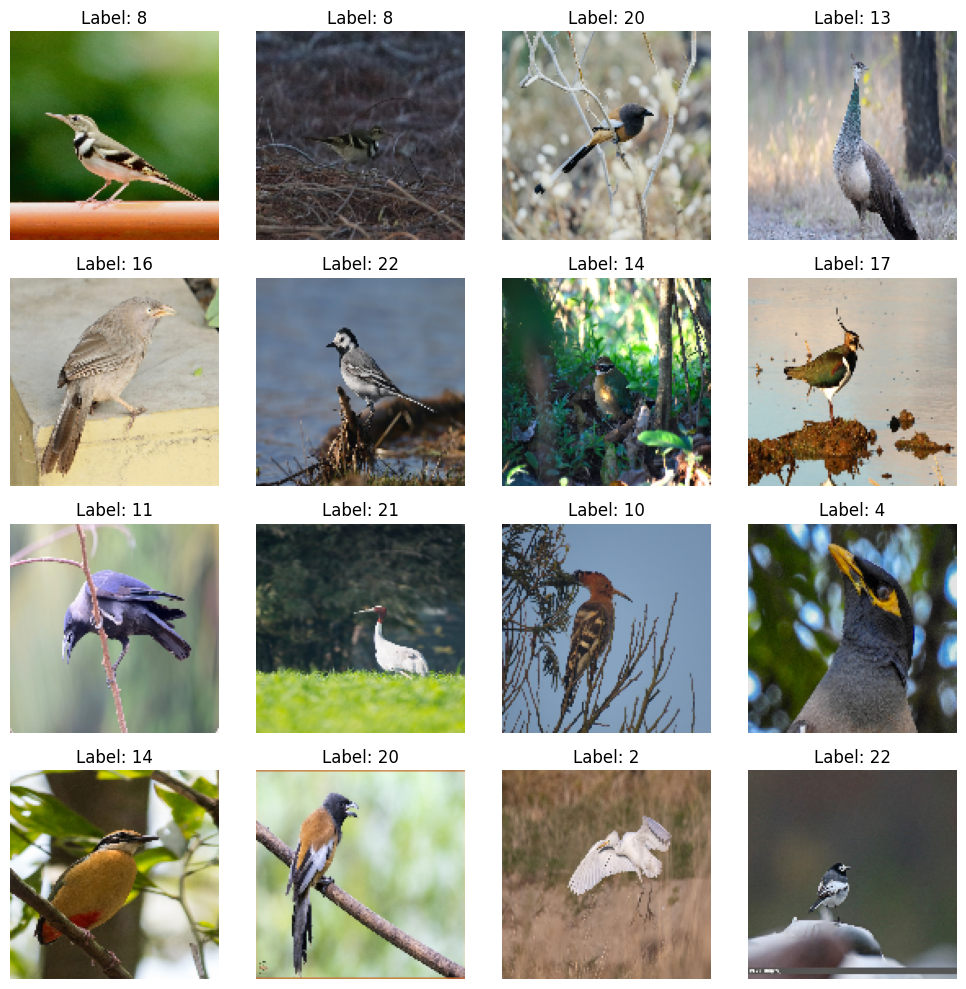

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i])
    plt.title(f'Label: {train_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Entrenamiento del modelo

In [ ]:
image_size = 128
num_classes = dftrain['labels'].nunique()

In [ ]:
def build_model():
    model = models.Sequential()

    # Capas conovolucionales

    input_layer = layers.Input(shape=(image_size, image_size, 3))
    conv1 = layers.Conv2D(image_size, (3, 3), padding='same', activation='relu')(input_layer)
    batch1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(batch1)

    conv2 = layers.Conv2D(image_size*2, (3, 3), padding='same', activation='relu')(pool1)
    batch2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(batch2)

    conv3 = layers.Conv2D(image_size*3, (3, 3), padding='same', activation='relu')(pool2)
    batch3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(batch3)

    conv4 = layers.Conv2D(image_size*4, (3, 3), padding='same', activation='relu')(pool3)
    batch4 = layers.BatchNormalization()(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(batch4)

    flatten = layers.Flatten()(pool4)
    dense1 = layers.Dense(image_size*4, activation='relu')(flatten)
    batchd = layers.BatchNormalization()(dense1)

    output_class = layers.Dense(num_classes, activation='softmax', name='output_class')(batchd)

    model = models.Model(inputs=input_layer, outputs=output_class)

    # Compilación del modelo
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',
                  metrics='accuracy')

    return model

In [ ]:
# Construcción del modelo Keras (ya compilado)
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  model = build_model()

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 256)       1024  

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Entrenando el modelo

num_epochs = 60

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.15,
    horizontal_flip=True
)

datagen.fit(train_images)

print(len(train_images))

# Callback Early Stopping
callback1 = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=2)

# Entrenamiento del modelo
history = model.fit(datagen.flow(train_images, train_labels, batch_size=32),
                    epochs=num_epochs, validation_data=(val_images, val_labels), callbacks=[callback1, reduce_lr])

# Evaluación del modelo
loss, class_accuracy= model.evaluate(test_images, test_labels)

15840
Epoch 1/60
495/495 [==============================] - 107s 188ms/step - loss: 2.8699 - accuracy: 0.2003 - val_loss: 2.7849 - val_accuracy: 0.2185 - lr: 0.0010
Epoch 2/60
495/495 [==============================] - 89s 179ms/step - loss: 2.0822 - accuracy: 0.3938 - val_loss: 1.5255 - val_accuracy: 0.5579 - lr: 0.0010
Epoch 3/60
495/495 [==============================] - 88s 178ms/step - loss: 1.5309 - accuracy: 0.5508 - val_loss: 1.3893 - val_accuracy: 0.5882 - lr: 0.0010
Epoch 4/60
495/495 [==============================] - 90s 181ms/step - loss: 1.2165 - accuracy: 0.6446 - val_loss: 1.5086 - val_accuracy: 0.6088 - lr: 0.0010
Epoch 5/60
495/495 [==============================] - 88s 179ms/step - loss: 1.0063 - accuracy: 0.7059 - val_loss: 0.8865 - val_accuracy: 0.7432 - lr: 0.0010
Epoch 6/60
495/495 [==============================] - 88s 178ms/step - loss: 0.8668 - accuracy: 0.7489 - val_loss: 0.7493 - val_accuracy: 0.7862 - lr: 0.0010
Epoch 7/60
495/495 [=========================

precisión: 88.63%